In [14]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import time

import cv2

## Prepare data

In [15]:
# Define the data to be used
DATASET = "../../datasets/dataset_3+8bags_3var3sc_regression_classification_kmeans_split/"


class TraversabilityDataset(Dataset):
    """Custom Dataset class to represent our dataset
    It includes data and information about the data

    Args:
        Dataset (class): Abstract class which represents a dataset
    """
    
    def __init__(self, traversal_costs_file, images_directory,
                 transform=None):
        """Constructor of the class

        Args:
            traversal_costs_file (string): Path to the csv file which contains
            images index and their associated traversal cost
            images_directory (string): Directory with all the images
            transform (callable, optional): Transforms to be applied on a
            sample. Defaults to None.
        """
        # Read the csv file
        self.traversal_costs_frame = pd.read_csv(traversal_costs_file)
        
        # Initialize the name of the images directory
        self.images_directory = images_directory
        
        # Initialize the transforms
        self.transform = transform

    def __len__(self):
        """Return the size of the dataset

        Returns:
            int: Number of samples
        """
        # Count the number of files in the image directory
        # return len(os.listdir(self.images_directory))
        return len(self.traversal_costs_frame)

    def __getitem__(self, idx):
        """Allow to access a sample by its index

        Args:
            idx (int): Index of a sample

        Returns:
            list: Sample at index idx
            ([image, traversal_cost])
        """
        # Get the image name at index idx
        image_name = os.path.join(self.images_directory,
                                  self.traversal_costs_frame.loc[idx, "image_id"])
        
        # Read the image
        image = Image.open(image_name)
        
        # Eventually apply transforms to the image
        if self.transform:
            image = self.transform(image)
        
        # Get the corresponding traversal cost
        traversal_cost = self.traversal_costs_frame.loc[idx, "traversal_cost"]
        
        # Get the corresponding traversability label
        traversability_label = self.traversal_costs_frame.loc[idx, "traversability_label"]

        return image, traversal_cost, traversability_label
 

# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    
    # Perform horizontal flip of the image with a probability of 0.5
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Modify the brightness and the contrast of the image
    transforms.ColorJitter(contrast=0.5, brightness=0.5),
    
    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Add some random gaussian noise to the image
    transforms.Lambda(lambda x: x + (0.001**0.5)*torch.randn(x.shape)),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    # transforms.Grayscale(),
    # transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


# # Create a Dataset instance for our training data
# data = TraversabilityDataset(
#     traversal_costs_file=DATASET+"traversal_costs.csv",
#     images_directory=DATASET+"images",
#     transform=train_transform
# )

# # Split our training dataset into a training dataset and a validation dataset
# train_set, val_set, test_set = random_split(data, [0.8, 0.1, 0.1])


# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform=train_transform
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform=test_transform
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_test.csv",
    images_directory=DATASET+"images_test",
    transform=test_transform
)

# Set the train dataset size
# 70% of the total data is used for training, 15% for validation
# and 15% for testing
train_size = 70/(100-15)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)), train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


BATCH_SIZE = 32

# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [16]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [17]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (6239 samples)
15.0 % of the data for validation (1337 samples)
15.0 % of the data for testing (1338 samples)


In [20]:
print(len(train_loader.dataset))

195


## GPU?

In [18]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Model design and initialization

In [6]:
# Open TensorBoard
tensorboard = SummaryWriter()

# Load the pre-trained ResNet model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device=device)

# Replace the last layer by a fully-connected one with N outputs
# (N being the number of classes)
model.fc = nn.Linear(model.fc.in_features, 10, device=device)

# Display the architecture in TensorBoard
images, traversal_costs, traversability_labels = next(iter(train_loader))
images = images.to(device)
tensorboard.add_graph(model, images)

# print(model)
# print(torchsummary.summary(model, (3, 100, 100)))

# Initialize the last layer using Xavier initialization
nn.init.xavier_uniform_(model.fc.weight)

Parameter containing:
tensor([[ 0.0732,  0.0339,  0.0991,  ..., -0.1010,  0.0647, -0.0498],
        [ 0.0857, -0.0189, -0.0119,  ...,  0.0490,  0.0172, -0.0968],
        [-0.0772, -0.1034, -0.0432,  ..., -0.1044, -0.0593,  0.0474],
        ...,
        [ 0.0381,  0.0163,  0.0429,  ...,  0.0390,  0.0531,  0.0706],
        [-0.1005, -0.0338, -0.0790,  ..., -0.0153, -0.0704,  0.0238],
        [-0.0441,  0.0462,  0.0614,  ...,  0.1017, -0.0448,  0.0354]],
       device='cuda:0', requires_grad=True)

In [7]:
[(name, param.shape) for name, param in model.named_parameters()]

[('conv1.weight', torch.Size([64, 3, 7, 7])),
 ('bn1.weight', torch.Size([64])),
 ('bn1.bias', torch.Size([64])),
 ('layer1.0.conv1.weight', torch.Size([64, 64, 3, 3])),
 ('layer1.0.bn1.weight', torch.Size([64])),
 ('layer1.0.bn1.bias', torch.Size([64])),
 ('layer1.0.conv2.weight', torch.Size([64, 64, 3, 3])),
 ('layer1.0.bn2.weight', torch.Size([64])),
 ('layer1.0.bn2.bias', torch.Size([64])),
 ('layer1.1.conv1.weight', torch.Size([64, 64, 3, 3])),
 ('layer1.1.bn1.weight', torch.Size([64])),
 ('layer1.1.bn1.bias', torch.Size([64])),
 ('layer1.1.conv2.weight', torch.Size([64, 64, 3, 3])),
 ('layer1.1.bn2.weight', torch.Size([64])),
 ('layer1.1.bn2.bias', torch.Size([64])),
 ('layer2.0.conv1.weight', torch.Size([128, 64, 3, 3])),
 ('layer2.0.bn1.weight', torch.Size([128])),
 ('layer2.0.bn1.bias', torch.Size([128])),
 ('layer2.0.conv2.weight', torch.Size([128, 128, 3, 3])),
 ('layer2.0.bn2.weight', torch.Size([128])),
 ('layer2.0.bn2.bias', torch.Size([128])),
 ('layer2.0.downsample.0.we

In [8]:
print(model.fc.state_dict())

OrderedDict([('weight', tensor([[ 0.0732,  0.0339,  0.0991,  ..., -0.1010,  0.0647, -0.0498],
        [ 0.0857, -0.0189, -0.0119,  ...,  0.0490,  0.0172, -0.0968],
        [-0.0772, -0.1034, -0.0432,  ..., -0.1044, -0.0593,  0.0474],
        ...,
        [ 0.0381,  0.0163,  0.0429,  ...,  0.0390,  0.0531,  0.0706],
        [-0.1005, -0.0338, -0.0790,  ..., -0.0153, -0.0704,  0.0238],
        [-0.0441,  0.0462,  0.0614,  ...,  0.1017, -0.0448,  0.0354]],
       device='cuda:0')), ('bias', tensor([ 0.0297, -0.0105, -0.0192, -0.0220, -0.0426, -0.0267,  0.0122, -0.0220,
         0.0281,  0.0407], device='cuda:0'))])


## Training and validation loops

In [9]:
# Define the loss function (combines nn.LogSoftmax() and nn.NLLLoss())
criterion_classification = nn.CrossEntropyLoss()

# Loss function to compare the expected traversal cost over the bins
# and the ground truth traversal cost
criterion_regression = nn.MSELoss()

# Load the bins midpoints
bins_midpoints = np.load(DATASET+"bins_midpoints.npy")
bins_midpoints = torch.tensor(bins_midpoints[:, None], dtype=torch.float32, device=device)

# Get all the parameters excepts the weights and bias of fc layer
base_params = [param for name, param in model.named_parameters()
               if name not in ["fc.weight", "fc.bias"]]

# Define the optimizer, with a greater learning rate for the new fc layer
optimizer = optim.SGD([
    {"params": base_params},
    {"params": model.fc.parameters(), "lr": 1e-3},
],
    lr=1e-4, momentum=0.9, weight_decay=0.001)

# An epoch is one complete pass of the training dataset through the network
NB_EPOCHS = 40

loss_values = torch.zeros(2, NB_EPOCHS)
accuracy_values = torch.zeros(2, NB_EPOCHS)
regression_loss_values = torch.zeros(2, NB_EPOCHS)

# Loop over the epochs
for epoch in range(NB_EPOCHS):
    
    # Training
    train_loss = 0.
    train_correct = 0
    train_regression_loss = 0.
    
    # Configure the model for training
    # (good practice, only necessary if the model operates differently for
    # training and validation)
    model.train()
    
    # Add a progress bar
    train_loader_pbar = tqdm(train_loader, unit="batch")
    
    # Loop over the training batches
    for images, traversal_costs, traversability_labels in train_loader_pbar:
        
        # Print the epoch and training mode
        train_loader_pbar.set_description(f"Epoch {epoch} [train]")
        
        # Move images and traversal scores to GPU (if available)
        images = images.to(device)
        traversal_costs = traversal_costs.to(device)
        traversability_labels = traversability_labels.to(device)
        
        # Zero out gradients before each backpropagation pass, to avoid that
        # they accumulate
        optimizer.zero_grad()
        
        # Perform forward pass
        predicted_traversability_labels = model(images)
        # predicted_traversal_scores = nn.Softmax(dim=1)(model(images))
        
        # Compute loss 
        loss = criterion_classification(predicted_traversability_labels, traversability_labels)
        
        # Print the batch loss next to the progress bar
        train_loader_pbar.set_postfix(batch_loss=loss.item())
        
        # Perform backpropagation (update weights)
        loss.backward()
        
        # Adjust parameters based on gradients
        optimizer.step()
        
        # Accumulate batch loss to average over the epoch
        train_loss += loss.item()
    
        # Get the number of correct predictions
        train_correct += torch.sum(
            torch.argmax(predicted_traversability_labels, dim=1) == traversability_labels
            ).item()
        
        # Compute the expected traversal cost over the bins
        expected_traversal_costs = torch.matmul(nn.Softmax(dim=1)(predicted_traversability_labels), bins_midpoints)
        
        # Compute and accumulate the batch loss
        train_regression_loss += criterion_regression(expected_traversal_costs[:, 0], traversal_costs).item()
    
    
    # Validation
    val_loss = 0.
    val_correct = 0
    val_regression_loss = 0.
    
    # Configure the model for testing
    # (turn off dropout layers, batchnorm layers, etc)
    model.eval()
    
    # Add a progress bar
    val_loader_pbar = tqdm(val_loader, unit="batch")
    
    # Turn off gradients computation (the backward computational graph is built during
    # the forward pass and weights are updated during the backward pass, here we avoid
    # building the graph)
    with torch.no_grad():
        # Loop over the validation batches
        for images, traversal_costs, traversability_labels in val_loader_pbar:

            # Print the epoch and validation mode
            val_loader_pbar.set_description(f"Epoch {epoch} [val]")

            # Move images and traversal scores to GPU (if available)
            images = images.to(device)
            traversal_costs = traversal_costs.to(device)
            traversability_labels = traversability_labels.to(device)
            
            # Perform forward pass (only, no backpropagation)
            predicted_traversability_labels = model(images)
            # predicted_traversal_scores = nn.Softmax(dim=1)(model(images))

            # Compute loss
            loss = criterion_classification(predicted_traversability_labels, traversability_labels)

            # Print the batch loss next to the progress bar
            val_loader_pbar.set_postfix(batch_loss=loss.item())

            # Accumulate batch loss to average over the epoch
            val_loss += loss.item()
            
            # Get the number of correct predictions
            val_correct += torch.sum(
                torch.argmax(predicted_traversability_labels, dim=1) == traversability_labels
                ).item()
            
            # Compute the expected traversal cost over the bins
            expected_traversal_costs = torch.matmul(nn.Softmax(dim=1)(predicted_traversability_labels), bins_midpoints)

            # Compute and accumulate the batch loss
            val_regression_loss += criterion_regression(expected_traversal_costs[:, 0], traversal_costs).item()
    
    
    # Compute the losses and accuracies
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    train_accuracy = 100*train_correct/NB_TRAIN
    val_accuracy = 100*val_correct/NB_VAL
    
    train_regression_loss /= len(train_loader)
    val_regression_loss /= len(val_loader)
    
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    print("Train regression loss: ", train_regression_loss)
    print("Validation regression loss: ", val_regression_loss)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy
    # Store the computed regression losses
    regression_loss_values[0, epoch] = train_regression_loss
    regression_loss_values[1, epoch] = val_regression_loss
    
    # Add the losses to TensorBoard
    tensorboard.add_scalar("train_loss", train_loss, epoch)
    tensorboard.add_scalar("val_loss", val_loss, epoch)
    # Add the accuracies to TensorBoard
    tensorboard.add_scalar("train_accuracy", train_accuracy, epoch)
    tensorboard.add_scalar("val_accuracy", val_accuracy, epoch)
    # Add the regression losses to TensorBoard
    tensorboard.add_scalar("train_regression_loss", train_regression_loss, epoch)
    tensorboard.add_scalar("val_regression_loss", val_regression_loss, epoch)

# Close TensorBoard
tensorboard.close()

Epoch 0 [val]: 100%|██████████| 42/42 [00:01<00:00, 35.82batch/s, batch_loss=1.94]


Train accuracy:  24.52316076294278
Validation accuracy:  26.925953627524308
Train regression loss:  0.06626318856501304
Validation regression loss:  0.05983901895850585


Epoch 1 [val]: 100%|██████████| 42/42 [00:01<00:00, 35.00batch/s, batch_loss=1.82]


Train accuracy:  28.834749158518992
Validation accuracy:  26.402393418100225
Train regression loss:  0.049672318182236344
Validation regression loss:  0.058814523001531054


Epoch 2 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.32batch/s, batch_loss=1.74]


Train accuracy:  30.854303574290753
Validation accuracy:  26.776364996260284
Train regression loss:  0.04656361683741712
Validation regression loss:  0.06584015385694386


Epoch 3 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.97batch/s, batch_loss=1.8] 


Train accuracy:  32.761660522519634
Validation accuracy:  29.020194465220644
Train regression loss:  0.0442164997246839
Validation regression loss:  0.060296825743019256


Epoch 4 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.25batch/s, batch_loss=2.01]


Train accuracy:  33.53101458567078
Validation accuracy:  28.646222887060585
Train regression loss:  0.043121184476077955
Validation regression loss:  0.05929426831487396


Epoch 5 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.26batch/s, batch_loss=1.77]


Train accuracy:  33.53101458567078
Validation accuracy:  27.898279730740462
Train regression loss:  0.042458017377640864
Validation regression loss:  0.06008637981962249


Epoch 6 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.78batch/s, batch_loss=1.96]


Train accuracy:  33.54704279531976
Validation accuracy:  26.701570680628272
Train regression loss:  0.040707160813067196
Validation regression loss:  0.058791926922975385


Epoch 7 [val]: 100%|██████████| 42/42 [00:01<00:00, 36.01batch/s, batch_loss=1.74]


Train accuracy:  34.58887642250361
Validation accuracy:  27.225130890052355
Train regression loss:  0.040554656009559986
Validation regression loss:  0.05792301553416844


Epoch 8 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.52batch/s, batch_loss=1.92]


Train accuracy:  35.614681840038465
Validation accuracy:  25.35527299925206
Train regression loss:  0.03924655594105038
Validation regression loss:  0.05584010333958903


Epoch 9 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.52batch/s, batch_loss=1.83]


Train accuracy:  36.72062830581824
Validation accuracy:  29.169783096484668
Train regression loss:  0.03866168786374684
Validation regression loss:  0.050613042811032315


Epoch 10 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.95batch/s, batch_loss=1.72]


Train accuracy:  37.313672062830584
Validation accuracy:  26.327599102468213
Train regression loss:  0.03840689003184612
Validation regression loss:  0.06421855960472411


Epoch 11 [val]: 100%|██████████| 42/42 [00:01<00:00, 37.07batch/s, batch_loss=1.82]


Train accuracy:  37.92274402949191
Validation accuracy:  26.028421839940165
Train regression loss:  0.037388923946032326
Validation regression loss:  0.05398200359468442


Epoch 12 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.93batch/s, batch_loss=1.67]


Train accuracy:  37.23353101458567
Validation accuracy:  28.42183994016455
Train regression loss:  0.037196810382451324
Validation regression loss:  0.05293694746413042


Epoch 13 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.84batch/s, batch_loss=2.42]


Train accuracy:  39.09280333386761
Validation accuracy:  31.039640987284965
Train regression loss:  0.03661769897988706
Validation regression loss:  0.047585229930836526


Epoch 14 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.51batch/s, batch_loss=1.87]


Train accuracy:  39.028690495271675
Validation accuracy:  26.477187733732237
Train regression loss:  0.036025466078667114
Validation regression loss:  0.04865571328486864


Epoch 15 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.61batch/s, batch_loss=1.54]


Train accuracy:  39.70187530052893
Validation accuracy:  28.571428571428573
Train regression loss:  0.03638954012653003
Validation regression loss:  0.04899415500357761


Epoch 16 [val]: 100%|██████████| 42/42 [00:01<00:00, 31.79batch/s, batch_loss=1.73]


Train accuracy:  40.00641128385959
Validation accuracy:  29.094988780852656
Train regression loss:  0.03475531330405383
Validation regression loss:  0.050295714338125845


Epoch 17 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.05batch/s, batch_loss=1.71]


Train accuracy:  39.84612918736977
Validation accuracy:  30.216903515332834
Train regression loss:  0.035527386699678476
Validation regression loss:  0.0490633420542185


Epoch 18 [val]: 100%|██████████| 42/42 [00:01<00:00, 30.69batch/s, batch_loss=1.63]


Train accuracy:  40.98413207244751
Validation accuracy:  32.38593866866118
Train regression loss:  0.03493379084379837
Validation regression loss:  0.04722000307908841


Epoch 19 [val]: 100%|██████████| 42/42 [00:01<00:00, 36.82batch/s, batch_loss=1.56]


Train accuracy:  40.61548325052092
Validation accuracy:  30.590875093492894
Train regression loss:  0.034952961843051154
Validation regression loss:  0.049778304441499444


Epoch 20 [val]: 100%|██████████| 42/42 [00:01<00:00, 31.59batch/s, batch_loss=1.42]


Train accuracy:  42.18624779612117
Validation accuracy:  29.24457741211668
Train regression loss:  0.0345246466161667
Validation regression loss:  0.04806560245794399


Epoch 21 [val]: 100%|██████████| 42/42 [00:01<00:00, 36.30batch/s, batch_loss=1.47]


Train accuracy:  42.10610674787626
Validation accuracy:  29.768137621540763
Train regression loss:  0.033800102807616826
Validation regression loss:  0.047177210475301476


Epoch 22 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.18batch/s, batch_loss=1.86]


Train accuracy:  43.11588395576214
Validation accuracy:  28.49663425579656
Train regression loss:  0.032926866239874494
Validation regression loss:  0.049462373359216716


Epoch 23 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.21batch/s, batch_loss=1.52]


Train accuracy:  43.228081423305014
Validation accuracy:  30.89005235602094
Train regression loss:  0.033164671094963884
Validation regression loss:  0.048572717178406034


Epoch 24 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.37batch/s, batch_loss=1.59]


Train accuracy:  44.89501522679917
Validation accuracy:  30.44128646222887
Train regression loss:  0.03223665789203576
Validation regression loss:  0.044804649173616255


Epoch 25 [val]: 100%|██████████| 42/42 [00:01<00:00, 35.64batch/s, batch_loss=1.9] 


Train accuracy:  43.53261740663568
Validation accuracy:  30.81525804038893
Train regression loss:  0.03206535107207807
Validation regression loss:  0.04401808950404159


Epoch 26 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.96batch/s, batch_loss=1.96]


Train accuracy:  45.24763583907678
Validation accuracy:  29.842931937172775
Train regression loss:  0.031177152616286168
Validation regression loss:  0.05297063277966873


Epoch 27 [val]: 100%|██████████| 42/42 [00:01<00:00, 36.14batch/s, batch_loss=1.65]


Train accuracy:  45.07132553293797
Validation accuracy:  29.094988780852656
Train regression loss:  0.032161926537383256
Validation regression loss:  0.045658541276331545


Epoch 28 [val]: 100%|██████████| 42/42 [00:01<00:00, 36.10batch/s, batch_loss=1.65]


Train accuracy:  44.9591280653951
Validation accuracy:  29.319371727748692
Train regression loss:  0.03170807383747867
Validation regression loss:  0.047065383987686324


Epoch 29 [val]: 100%|██████████| 42/42 [00:01<00:00, 35.38batch/s, batch_loss=2.14]


Train accuracy:  46.56194903029331
Validation accuracy:  30.590875093492894
Train regression loss:  0.030367564128798756
Validation regression loss:  0.05220327277107014


Epoch 30 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.64batch/s, batch_loss=2.03]


Train accuracy:  47.36335951274243
Validation accuracy:  30.142109199700823
Train regression loss:  0.030597794490374093
Validation regression loss:  0.04739409218808296


Epoch 31 [val]: 100%|██████████| 42/42 [00:01<00:00, 36.09batch/s, batch_loss=1.87]


Train accuracy:  47.860234011860875
Validation accuracy:  28.19745699326851
Train regression loss:  0.03154695013796543
Validation regression loss:  0.04794914736874075


Epoch 32 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.53batch/s, batch_loss=1.75]


Train accuracy:  47.748036544318
Validation accuracy:  30.516080777860882
Train regression loss:  0.030489903424647066
Validation regression loss:  0.04734683098127769


Epoch 33 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.02batch/s, batch_loss=1.51]


Train accuracy:  48.59753165571406
Validation accuracy:  33.95661929693343
Train regression loss:  0.030168191340095282
Validation regression loss:  0.04515045409186934


Epoch 34 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.58batch/s, batch_loss=1.75]


Train accuracy:  49.23866004167334
Validation accuracy:  30.81525804038893
Train regression loss:  0.029715125070257774
Validation regression loss:  0.04781874058212998


Epoch 35 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.43batch/s, batch_loss=1.74]


Train accuracy:  50.50488860394294
Validation accuracy:  32.38593866866118
Train regression loss:  0.029598618764111715
Validation regression loss:  0.045006030938332386


Epoch 36 [val]: 100%|██████████| 42/42 [00:01<00:00, 36.13batch/s, batch_loss=1.88]


Train accuracy:  50.07212694342042
Validation accuracy:  30.216903515332834
Train regression loss:  0.028727683988376614
Validation regression loss:  0.0473400172360045


Epoch 37 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.71batch/s, batch_loss=1.6] 


Train accuracy:  50.82545279692258
Validation accuracy:  30.964846671652953
Train regression loss:  0.027795900073199407
Validation regression loss:  0.0447324092509903


Epoch 38 [val]: 100%|██████████| 42/42 [00:01<00:00, 35.07batch/s, batch_loss=1.7] 


Train accuracy:  51.01779131271037
Validation accuracy:  30.89005235602094
Train regression loss:  0.029355337164152936
Validation regression loss:  0.04588741505018678


Epoch 39 [val]: 100%|██████████| 42/42 [00:01<00:00, 31.09batch/s, batch_loss=1.85]

Train accuracy:  52.47635839076775
Validation accuracy:  32.53552729992521
Train regression loss:  0.02786337353147077
Validation regression loss:  0.04241229830185623


### Visualization

Text(0.5, 0, 'Epoch')

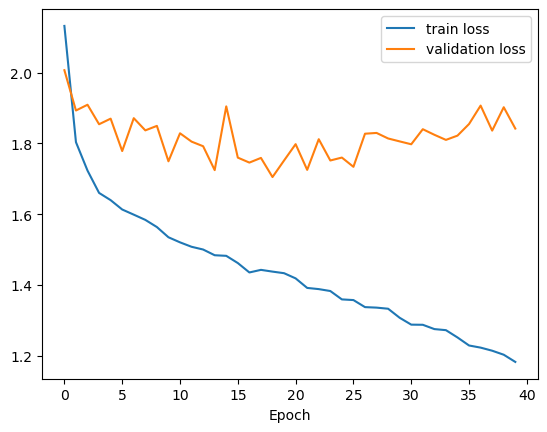

In [10]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="validation loss")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

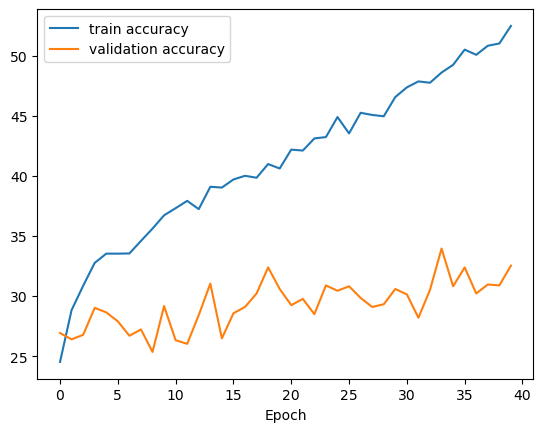

In [11]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, label="train accuracy")
plt.plot(val_accuracies, label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

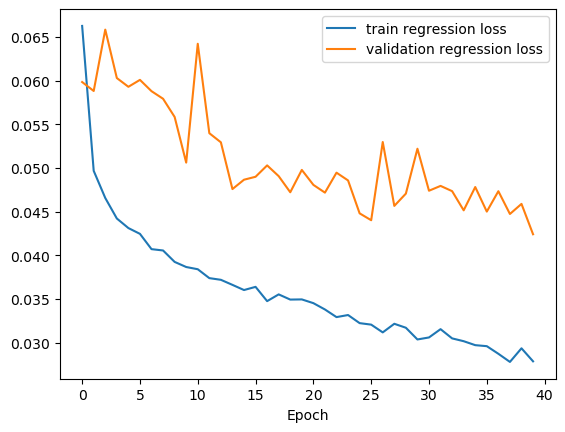

In [12]:
# Regression loss
train_regression_losses = regression_loss_values[0]
val_regression_losses = regression_loss_values[1]

plt.plot(train_regression_losses, label="train regression loss")
plt.plot(val_regression_losses, label="validation regression loss")

plt.legend()
plt.xlabel("Epoch")

## Testing

In [13]:
# Testing
test_loss = 0.
test_correct = 0
test_regression_loss = 0.

# Configure the model for testing
model.eval()

with torch.no_grad():
    # Loop over the testing batches
    for images, traversal_costs, traversability_labels in test_loader:
        
        images = images.to(device)
        traversal_costs = traversal_costs.to(device)
        traversability_labels = traversability_labels.to(device)
        
        # Perform forward pass
        predicted_traversability_labels = model(images)
        
        # Compute loss
        loss = criterion_classification(predicted_traversability_labels, traversability_labels)
        
        # Accumulate batch loss to average of the entire testing set
        test_loss += loss.item()
        
        # Get the number of correct predictions
        test_correct += torch.sum(
            torch.argmax(predicted_traversability_labels, dim=1) == traversability_labels
            ).item()

        # Compute the expected traversal cost over the bins
        expected_traversal_costs = torch.matmul(nn.Softmax(dim=1)(predicted_traversability_labels), bins_midpoints)
        # Compute and accumulate the batch loss
        test_regression_loss += criterion_regression(expected_traversal_costs[:, 0], traversal_costs).item()
        
        
# Compute the loss and accuracy
test_loss /= len(test_loader)
test_accuracy = 100*test_correct/NB_TEST

print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

test_regression_loss /= len(test_loader)

print("Regression loss: ", test_regression_loss)

Test loss:  1.875060879048847
Test accuracy:  30.86696562032885
Regression loss:  0.042249552165416


In [73]:
images, traversal_scores = next(iter(test_loader))

images = images.to(device)
traversal_scores = traversal_scores.to(device)

predicted_traversal_scores = model(images)
# predicted_traversal_scores = nn.Softmax(dim=1)(model(images))

print("Output:\n", predicted_traversal_scores)
print("Softmax output:\n", nn.Softmax(dim=1)(predicted_traversal_scores))
print("Prediction:\n", torch.argmax(predicted_traversal_scores, dim=1))
print("Ground truth:\n", traversal_scores)

# print(predicted_traversal_scores-traversal_scores)

# predicted_traversal_scores = predicted_traversal_scores.to("cpu").detach().numpy()
# plt.hist(predicted_traversal_scores)


Output:
 tensor([[-0.8515,  0.0069,  1.1660,  0.8941,  2.0173,  1.7717,  1.0256,  0.6969,
          0.6718, -0.0951],
        [-1.6083, -1.6581,  0.0175, -0.4592,  0.1121,  2.2562,  4.1061,  4.5848,
          2.8257, -0.1665],
        [-0.6184, -1.7743,  1.2221,  0.7353,  1.7184,  2.4739,  0.7050,  0.2858,
         -0.2344,  1.0759],
        [-2.2887, -1.7999, -3.2661, -2.3329, -1.6021,  3.9827,  6.3289,  5.8019,
          4.0995,  0.4638],
        [-2.3536, -2.3906,  0.8915, -0.1349,  2.4820,  2.0621,  2.7095,  2.4689,
          0.5712,  1.3396],
        [-0.7196,  2.5418,  2.0863,  1.8257,  1.8399,  0.2246, -0.6465,  0.1092,
         -0.1289, -0.7326],
        [-2.1995, -0.4077,  1.9363,  0.9856,  2.1627,  2.2628,  0.9170,  1.0320,
          1.6215, -0.8201],
        [-0.4454,  1.0630,  1.3040,  0.5371,  1.3248,  1.6151,  1.1244,  0.4658,
         -0.4242,  0.5076],
        [-1.3742, -2.2342,  1.1690, -0.7643,  1.0619,  2.0883,  2.0469,  2.8033,
          1.2164,  1.2618],
        [-

(array([  58.,  323.,  565.,  727.,  665.,  921., 1330., 1083.,  458.,
         109.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

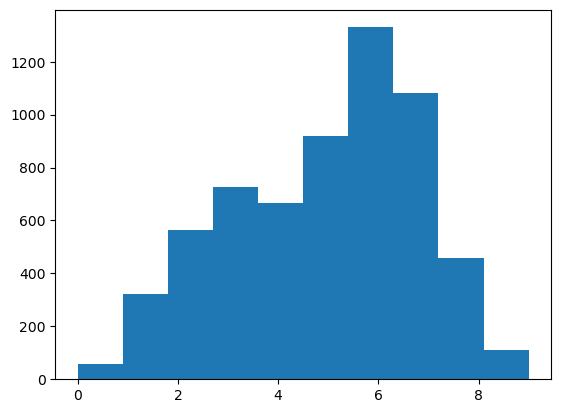

In [74]:
traversal_scores_train = []

for _, score in train_set:
    traversal_scores_train.append(score)
    
# print(traversal_scores_train)
plt.hist(traversal_scores_train, bins=10)

## Save model parameters

In [ ]:
# Save the model parameters
torch.save(model.state_dict(), "resnet18_fine_tuned_3+8bags_3var3sc_classification_kmeans_100epochs.params")